In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve
from pathlib import Path 
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

### Functions

In [2]:
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

In [50]:
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
        deaths = [x-minus for x in deaths]
    else:
        deaths = data["cumDeath"]-data["cumDeath"].loc[offset]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, len(deaths), len(deaths))
    graph.plot(t, deaths, 'r', marker='.', label="Data", linestyle = 'None')
    legend = graph.legend()
    legend.get_frame().set_alpha(0.5)
    return graph

### SIRD Model
differential equation of the SIRD model.

In [4]:
# SIRD model divided into its equations
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = (beta * S * I / N) - ((gamma+rho) * I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

In [5]:
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true, name):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 


    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t+offset, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t+offset, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, D, alpha=1, lw=2, label=name)


    # Creating Labels for graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    ax.set_label(name)
    # ax.fill_between(t+offset, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D

In [6]:
def getSIRD(tf, N, i0, beta, gamma, rho, sd):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 

    return S,I,R,D

In [32]:
dataset = {
'Switzerland' : {
        'data' : pd.read_csv("../processed_data/cumDeathSwitzerland.csv"),
        'fLock' : ['2020-03-17', '2020-04-27'],
        'sLock' : ['2021-01-18', '2021-03-01'],
        'pop' : 8570146
        },
    'Sweden' : {
        'data' : pd.read_csv("../processed_data/cumDeathSweden.csv"),
        'fLock' : ['2020-03-21', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 10420000
        },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
            },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Netherlands' : {
        'data' : pd.read_csv("../processed_data/cumDeathNetherlands.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 17606800
            }
}

### R2 and RMSE

In [70]:
country_names = ['Sweden','Switzerland','Italy']
values = []
for country in country_names:
    df = pd.DataFrame(columns=['days','r2','rmse','aic'])
    pop = dataset[country]['pop']
    df_real = dataset[country]['data']

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_real[df_real['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']


    for x in range(0,18,3):
        # Plug in parameters to the SIRD differential equation
        df_param = pd.read_csv('mcmc_data/'+country+"/analysis_"+str(x/3)+'.csv')
        sird = getSIRD(100,pop, df_param.loc[3][1],df_param.loc[0][1],df_param.loc[1][1],df_param.loc[2][1], [df_param.loc[0][2], df_param.loc[1][2], df_param.loc[2][2]] )

        deaths = df_real["cumDeath"].tolist()
        deaths_previous = deaths[startDate[0]-11]
        deaths = deaths[startDate[0]-10:startDate[0]+(x+5)]
        
        deaths_predicted = sird[3]
        deaths_predicted = deaths_predicted[0:15+x] + deaths_previous
        
        r2 = r2_score(deaths, deaths_predicted)
        rmse =  np.sqrt(mean_squared_log_error(deaths, deaths_predicted))
        # Calculate AIC
        n = len(deaths)
        k = 4 # number of parameters (beta and gamma)
        rss = np.sum((deaths-deaths_predicted)**2)
        aic = n * np.log(rss/n) + 2 * k
        df1 = pd.DataFrame(
        {
            "days": (x),
            "r2": r2,
            "rmse": rmse,
            "aic": aic
        }, index=[0])
        df = pd.concat([df,df1])

    values.append(df)

In [71]:
for x in values:
    display(x)

,days,r2,rmse,aic
0,0,0.967719,0.126928,66.947634
0,3,0.985012,0.292882,86.544571
0,6,0.988171,0.450670,114.697676
0,9,0.994054,0.462145,134.311823
0,12,0.921389,0.663292,232.511109
0,15,0.956634,0.830096,248.885234


,days,r2,rmse,aic
0,0,0.934823,0.191479,68.230097
0,3,0.982851,0.225889,75.254113
0,6,0.994238,0.249337,84.411732
0,9,0.991103,0.359731,127.350925
0,12,0.987171,0.542299,171.495202
0,15,0.976215,0.709464,224.877898


,days,r2,rmse,aic
0,0,0.803478,0.235100,162.097091
0,3,0.952678,0.167129,186.331352
0,6,0.981342,0.159728,215.811260
0,9,0.997007,0.302547,222.880285
0,12,0.988839,0.348040,304.120970
0,15,0.970164,0.467146,383.855134


### Graph

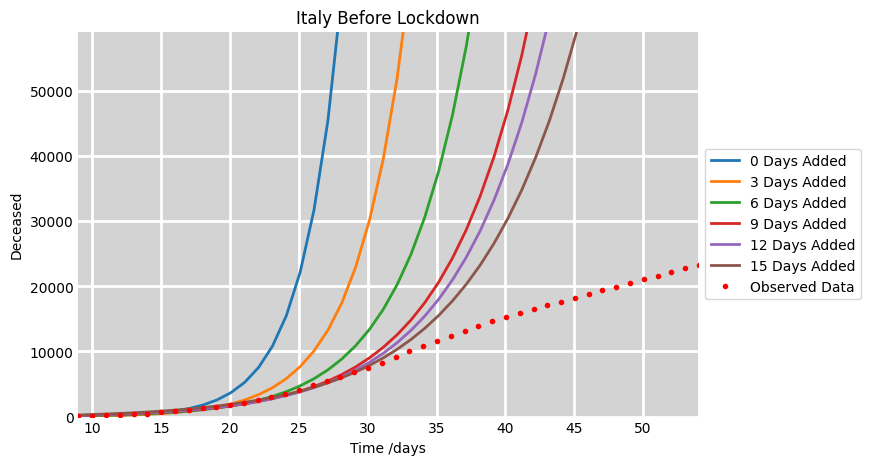

In [56]:
names=["0 Days Added","3 Days Added","6 Days Added","9 Days Added","12 Days Added","15 Days Added","Observed Data"]
country_names = ['Italy']
sird_deaths = {}
fildesDir = "mcmc_data/Italy/"
country = "Italy"
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.set_facecolor('lightgrey')
r_italy = []
file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv')]
file_list.sort()
for file in file_list:
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']


    obvData_start = timeTot(firstDate,startDate)-5
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv(file)
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False, file)
    r_italy.append(df.loc[4][1])

final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
ax1.set_title(country + " Before Lockdown")
ax1.legend(names,loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('results/sweden_analysis/'+country+'.png')

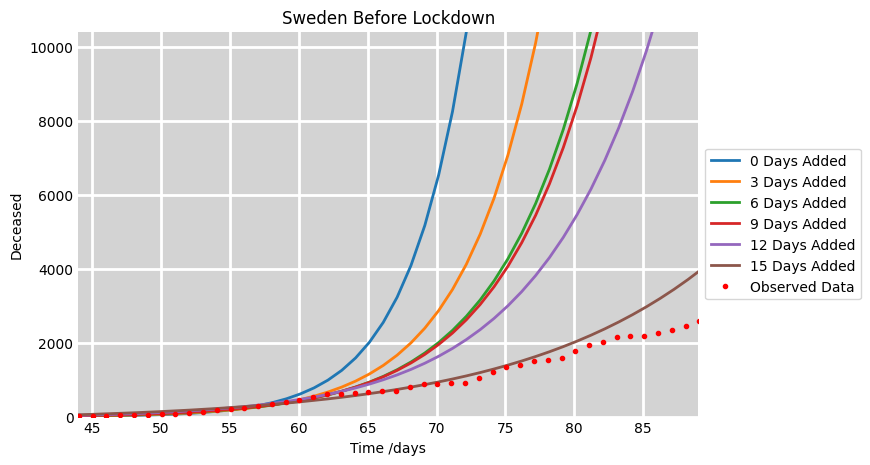

In [59]:
names=["0 Days Added","3 Days Added","6 Days Added","9 Days Added","12 Days Added","15 Days Added","Observed Data"]
country_names = ['Sweden']
sird_deaths = {}
fildesDir = "mcmc_data/Sweden/"
country = "Sweden"
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.set_facecolor('lightgrey')
r_sweden = []
file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv')]
file_list.sort()
for file in file_list:
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']


    obvData_start = timeTot(firstDate,startDate)-5
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv(file)
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False, file)
    r_sweden.append(df.loc[4][1])

final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
ax1.set_title(country + " Before Lockdown")
ax1.legend(names,loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('results/sweden_analysis/'+country+'.png')

['mcmc_data/Switzerland/analysis_0.0.csv', 'mcmc_data/Switzerland/analysis_1.0.csv', 'mcmc_data/Switzerland/analysis_2.0.csv', 'mcmc_data/Switzerland/analysis_3.0.csv', 'mcmc_data/Switzerland/analysis_4.0.csv', 'mcmc_data/Switzerland/analysis_5.0.csv']
mcmc_data/Switzerland/analysis_0.0.csv
mcmc_data/Switzerland/analysis_1.0.csv
mcmc_data/Switzerland/analysis_2.0.csv
mcmc_data/Switzerland/analysis_3.0.csv
mcmc_data/Switzerland/analysis_4.0.csv
mcmc_data/Switzerland/analysis_5.0.csv


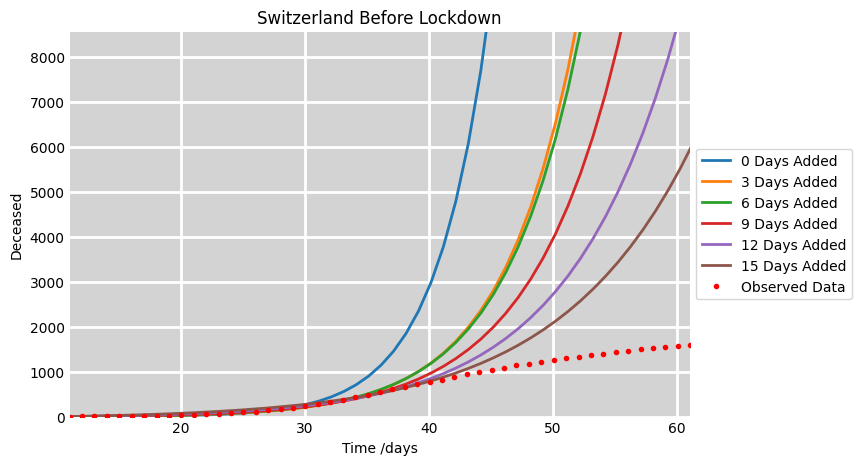

In [67]:
names=["0 Days Added","3 Days Added","6 Days Added","9 Days Added","12 Days Added","15 Days Added","Observed Data"]
country_names = ['Switzerland']
sird_deaths = {}
fildesDir = "mcmc_data/Switzerland/"
country = "Switzerland"
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.set_facecolor('lightgrey')
r_swiss = []
file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv')]
file_list.sort()
print(file_list)
for file in file_list:
    print(file)
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv(file)
    r_swiss.append(df.loc[4][1])
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False, file)

final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
ax1.set_title(country + " Before Lockdown")
ax1.legend(names,loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('results/sweden_analysis/'+country+'.png')

/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_4201/960158428.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([10,0,3,6,9,12,15])


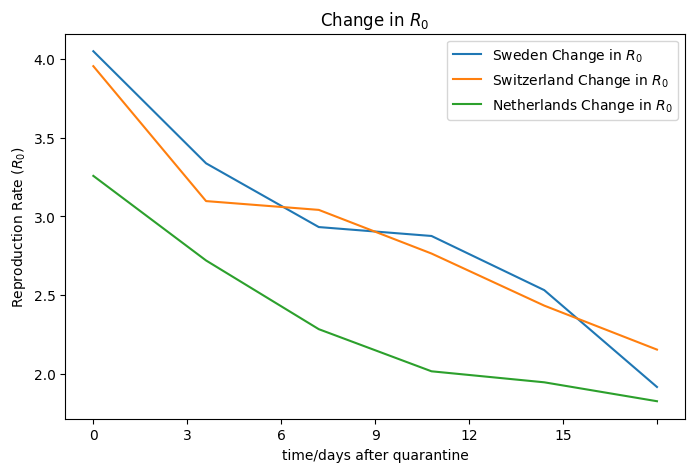

In [66]:
x = np.linspace(0,6,6)
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.plot(x,r_sweden, label="Sweden Change in $R_0$")
ax1.plot(x,r_swiss, label="Switzerland Change in $R_0$")
ax1.plot(x,r_italy, label="Netherlands Change in $R_0$")
ax1.set_xticklabels([10,0,3,6,9,12,15])
ax1.set_title("Change in $R_0$")
ax1.set_xlabel("time/days after quarantine")
ax1.set_ylabel("Reproduction Rate ($R_0$)")
ax1.legend()